In [3]:
from sentence_transformers import SentenceTransformer, util
import os

2021-11-26 16:26:24.295761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/gaoag/.mujoco/mujoco200/bin
2021-11-26 16:26:24.296067: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [5]:
from sklearn.decomposition import PCA

In [6]:
from sklearn.manifold import TSNE

In [7]:
import numpy as np

In [8]:
import matplotlib.pyplot as plt

In [9]:
import re

In [10]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [11]:
# construction tuples of (emotion, [sentences], source, filename/path)
all_entries = []
for directory in ["./friendship/", "./loneliness/"]:
    emotion = directory.split('/')[1]
    for filename in os.listdir(directory):
        txtstring = open(directory + filename, 'r').read().split("|_|")
        sentence_string = txtstring[0]
        try:
            source = txtstring[1]
        except IndexError as e:
            source = "Unknown"
            
        sentences = split_into_sentences(sentence_string)
        filtered_sentences = [s for s in sentences if s != "."]
        all_entries.append((emotion, filtered_sentences, source, directory+filename))
        
        
        


In [12]:
# now, we construct embeddings. We need a per-sentence embedding, as well as a document<->average embedding association.
# the following stores an emotion/source/filepath/embedding for EACH SENTENCE, SEPARATELY
individual_sentence_embeds = []
# the following stores an emotion/source/filepath/AVERAGE EMBEDDING FOR THE DOCUMENT
document_average_embeds = []
for entry in all_entries:
    emotion, sentences, source, filepath = entry[0], entry[1], entry[2], entry[3]
    embeddings = model.encode(sentences)
    num_sentences = len(sentences)
    if num_sentences == 0:
        print('empty sentence')
        continue
    individual_sentence_embeds.extend(list(zip(sentences, 
                                               embeddings,
                                               [emotion]*num_sentences,
                                               [source]*num_sentences, 
                                               [filepath]*num_sentences)))
    
    average_document_embedding = np.mean(embeddings, axis=0)
    document_average_embeds.append((sentences, average_document_embedding, emotion, source, filepath))

    

empty sentence


In [75]:
# explore whether these embeddings are at all linearly separable:
# create some x that is (num_documents, num_features)
x = np.array([doc[1] for doc in document_average_embeds])
y = np.array([doc[2] for doc in document_average_embeds])
pca = PCA()
principalComponents = pca.fit_transform(x)
pca.explained_variance_ratio_



array([1.0891427e-01, 6.7143053e-02, 5.9626132e-02, 4.4194516e-02,
       4.1131020e-02, 3.7319459e-02, 3.4801189e-02, 3.1468619e-02,
       3.0482030e-02, 2.6640605e-02, 2.4742229e-02, 2.3555126e-02,
       2.2430936e-02, 2.2077443e-02, 1.9338755e-02, 1.8759375e-02,
       1.8544905e-02, 1.6965384e-02, 1.6241709e-02, 1.5632268e-02,
       1.5013917e-02, 1.4556331e-02, 1.3720551e-02, 1.3333327e-02,
       1.2968779e-02, 1.1670519e-02, 1.1357782e-02, 1.0954650e-02,
       1.0212691e-02, 1.0037722e-02, 9.8072281e-03, 9.3729207e-03,
       8.9798020e-03, 8.2522966e-03, 7.8930510e-03, 7.6254611e-03,
       7.3946589e-03, 7.0234807e-03, 6.7302729e-03, 6.6773468e-03,
       6.2453449e-03, 5.8240802e-03, 5.6541385e-03, 5.4014279e-03,
       5.1994426e-03, 4.8228921e-03, 4.5770514e-03, 4.5298114e-03,
       4.2630038e-03, 4.0655746e-03, 3.8699817e-03, 3.6952232e-03,
       3.5515723e-03, 3.4604196e-03, 3.3832402e-03, 3.1515127e-03,
       3.0464749e-03, 2.9834851e-03, 2.8317892e-03, 2.8027571e

In [34]:
#embed some jouranl entry:
journal = '''
I went with my family yesterday to a beach in Palos Verdes. I enjoyed seeing the way my parents interacted with each other, and love showing my little sister all the stuff and watching her discover them for the first time. I was like, "do I want kids?"
'''

journaltest = '''
In September, The Oaklandside launched a reader survey to gather information about people’s experiences on our \
city’s dangerous roadways. More than a third of the 100-plus people who responded told us that red-light running \
is a major concern. Respondents were from neighborhoods across the city and included Black, Latinx, and Asian residents \
in the East Oakland flatlands, where collisions occur more frequently. One person told us that she saw a car burst through \
a red light on Grand Avenue and Mandela Parkway in West Oakland, colliding with another vehicle and throwing it in the air. \
It landed two feet from her car. Another Oaklander said he was hit by a car running a red light at an intersection downtown \
while biking to work but avoided serious injury by swerving. \

'''

journal_sentences = split_into_sentences(journaltest)
journal_embeddings = []
for d in journal_sentences:
    print(d)
    journal_embeddings.append((d, model.encode(d))) 

In September, The Oaklandside launched a reader survey to gather information about people’s experiences on our city’s dangerous roadways.
More than a third of the 100-plus people who responded told us that red-light running is a major concern.
Respondents were from neighborhoods across the city and included Black, Latinx, and Asian residents in the East Oakland flatlands, where collisions occur more frequently.
One person told us that she saw a car burst through a red light on Grand Avenue and Mandela Parkway in West Oakland, colliding with another vehicle and throwing it in the air.
It landed two feet from her car.
Another Oaklander said he was hit by a car running a red light at an intersection downtown while biking to work but avoided serious injury by swerving.


/home/gaoag/anaconda3/envs/tui/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gaoag/anaconda3/envs/tui/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


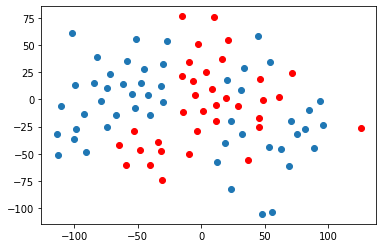

In [84]:
tsne = TSNE(perplexity=20)
result = tsne.fit_transform(np.array(x))
plt.scatter(result[np.where(y=='friendship')].T[0], result[np.where(y=='friendship')].T[1])
plt.scatter(result[np.where(y=='loneliness')].T[0], result[np.where(y=='loneliness')].T[1], color='r')

In [35]:
# find closest "average document" to each indivdual sentence; take closest ones
res = {}
all_entry_distance_pairs = []
for journal_sentence, journal_embedding in journal_embeddings:
    # look through document embedding pairs:
    entry_dist_pairs = []
    for entry in document_average_embeds:
        doc_sentences, average_document_embedding, emotion, source, filepath = entry[0], entry[1], entry[2], entry[3], entry[4]
        dist = np.linalg.norm(journal_embedding - average_document_embedding)
        all_entry_distance_pairs.append((journal_sentence, doc_sentences, dist, emotion, source, filepath))
    
# results is a sorted list in which we treat each journal sentence separately and compare it to the average documents
results = sorted(all_entry_distance_pairs, key=lambda x: x[2])[:5]
# this gives us a sorted list of the closest corpus entries to the individual journal sentences
connection_score = 0
for r in results:
    print(r[3])
    connection_score += {'friendship':1, 'loneliness':-1}[r[3]]
print(connection_score)

friendship
friendship
friendship
friendship
loneliness
3


In [36]:
results

[('It landed two feet from her car.',
  ['As I left a party, I got on the wrong freeway and was immediately lost.',
   'I pulled over to the shoulder and called my roadside-assistance provider.',
   'She tried to connect me to the California Highway Patrol, but that call never went through.',
   'Hearing the panic in my voice, she came up with a plan B: “You’re near this office,” she said.',
   '“I’m about to go off shift.',
   'Stay put, and I’ll find you”.',
   'Ten minutes later, she rolled up.',
   'She guided me not only to the right freeway but all the way to the correct freeway exit.',
   'And then, with a wave goodbye, she drove back into the night.'],
  0.89540017,
  'friendship',
  'Unknown',
  './friendship/24.txt'),
 ('It landed two feet from her car.',
  ['I’d pulled over onto the side of a New Mexico road and was suffering a panic attack when a minivan full of kids pulled over.',
   'A woman got out and asked if I was OK.',
   '“No,” I said.',
   'Then I laid out what had

In [93]:
# find closest "average document" to the average journal entry; take closest ones
res = {}
all_entry_distance_pairs_doc_to_doc = []
average_journal_embedding = np.mean(np.array([x[1] for x in journal_embeddings]), axis=0)
for entry in document_average_embeds:
    doc_sentences, average_document_embedding, emotion, source, filepath = entry[0], entry[1], entry[2], entry[3], entry[4]
    dist = np.linalg.norm(journal_embedding - average_document_embedding)
    all_entry_distance_pairs_doc_to_doc.append((journal_sentences, doc_sentences, dist, emotion, source, filepath))
    
# results is a sorted list in which we treat each journal sentence separately and compare it to the average documents
results_doc_to_doc = sorted(all_entry_distance_pairs_doc_to_doc, key=lambda x: x[2])[:10]
# this gives us a sorted list of the closest corpus entries to the average journal entry
connection_score = 0
for r in results_doc_to_doc:
    print(r[3])
    connection_score += {'friendship':1, 'loneliness':-1}[r[3]]
print(connection_score)

friendship
friendship
friendship
friendship
loneliness
friendship
friendship
friendship
friendship
loneliness
6


Now, we have to determine what segments to write out.

We can broadly do average-to-average, sentence-to-sentence, sentence-to-average, and average-to-sentence. 4 possibilities.
In terms of robustness - i like average to average - but the number of sentences output would be crazy D:

In [97]:
# determine what little segment to write out:
# the sentence, or the average document, that is the closest?

# reminder: "results" contains sentence-to-avg-doc-embedding relationships.
#           "results_doc_to_doc" contains avg-journal-to-avg-doc embedding relationships:

# this goes through the results, which has theh sentences that are closest to the average document
# and then finds the sentences within those closest-average-docs that are closest.

# NOTE: THIS APPROACH KIND OF SUCKS. SENTENCE-TO-SENTENCE MAPPING JUST = SPURIOUS MATCHINGS.

final_mapping = {}

for i in range(len(results)):
    closest_doc_sentences = results[i][1]
    closest_journal_sentence = results[i][0]
    closest_doc_sentence = ""
    min_dist = 1000000
    for sentence in closest_doc_sentences:
        new_dist = np.linalg.norm(model.encode(closest_journal_sentence) - model.encode(sentence))
        if new_dist < min_dist:
            min_dist = new_dist
            closest_doc_sentence = sentence
    final_mapping[i] = (closest_journal_sentence, closest_doc_sentence, min_dist)
final_mapping

{0: ('It was the first good birthday I had in college.',
  'My birthday was coming up, and for some reason this year I was kind of bummed about not being able to do a get-together for it.',
  0.8462396),
 1: ('Every year, my birthday is during dead week, so I never get to celebrate - however, this year, they surprised me with a cake!',
  'My birthday was coming up, and for some reason this year I was kind of bummed about not being able to do a get-together for it.',
  0.88649666),
 2: ('Every year, my birthday is during dead week, so I never get to celebrate - however, this year, they surprised me with a cake!',
  'Today is my birthday, and I know my friend Linda is making me a cake.',
  0.90343624),
 3: ('I worked on my homework quickly so I could join my friends at the party.',
  'One of them reached out to family and was able to get a sailboat for a weekend, so my birthday went from videogames by myself to my two best friends traveling hours to come sailing with me for a weekend.',


In [98]:
# SO, maybe we return the document. But that is SO long???

# reminder: "results" contains sentence-to-avg-doc-embedding relationships.
#           "results_doc_to_doc" contains avg-journal-to-avg-doc embedding relationships:

# this goes through the results, which has theh sentences that are closest to the average document
# and then finds the sentences within those closest-average-docs that are closest to the average journal?

closest_avg_doc = results_doc_to_doc[0]
for doc_sentence in closest_avg_doc[1]:
    

(['I worked on my homework quickly so I could join my friends at the party.',
  'Every year, my birthday is during dead week, so I never get to celebrate - however, this year, they surprised me with a cake!',
  'It was the first good birthday I had in college.'],
 ["I moved out to a small rural town for grad school a little over a year ago, and between grad school and the rural population, I hadn't really made any local friends.",
  'My birthday was coming up, and for some reason this year I was kind of bummed about not being able to do a get-together for it.',
  'I never did parties before, but this time it bothered me.',
  'And I never even said anything about it, but two weeks before my birthday, two of my best friends who live seven hours away in another country called me and asked if I had any birthday plans.',
  'They, on their own - not even conferring with each other!',
  '- had decided to make that trip out to me for a long weekend.',
  'One of them reached out to family and w

In [ ]:
# we need some way of filtering out for irrelevant paragraphs.....

In [ ]:
# what happens when the sentence/paragraph is long form? and more general?
# this turns basically into sentiment analysis along prompt axes:


In [ ]:
# find closest sentences

In [ ]:
# find closest "average document"
res = {}
all_entry_distance_pairs = []
for journal_sentence, journal_embedding in journal_embeddings:
    # look through document embedding pairs:
    entry_dist_pairs = []
    for emotion, entries in document_embedding_pairs.items():
        for corp_entry, avg_corp_embedding in entries:
            dist = np.linalg.norm(journal_sentence - avg_corp_embedding)
            all_entry_distance_pairs.append((entry, corp_entry, dist, emotion))
    
results = sorted(all_entry_distance_pairs, key=lambda x: x[2])
# this gives us a sorted list of the closest corpus entries to the nidividual sentence
connection_score = 0
for r in results:
    print(r[3])
    connection_score += {'friendship':1, 'loneliness':-1}[r[3]]
print(connection_score)

In [392]:
res = {}
all_entry_distance_pairs = []
for entry, journal_embedding in journal_embeddings:
    # look through document embedding pairs:
    saved_emotion = ""
    entry_dist_pairs = []
    for emotion, entries in document_embedding_pairs.items():
        for corp_entry, avg_corp_embedding in entries:
            dist = np.linalg.norm(journal_embedding - avg_corp_embedding)
            entry_dist_pairs.append((entry, corp_entry, dist, emotion))
    
    all_entry_distance_pairs.extend(entry_dist_pairs)
    
#     res[entry] = sorted(entry_dist_pairs, key=lambda x: x[1])[:5]
    
    
#     for corp_sentence, corp_embedding in sentence_embedding_pairs:
#         dist = np.linalg.norm(journal_embedding - corp_embedding)
#         if dist < min_dist:
#             curr_closest = corp_sentence
#             min_dist = dist
#     res[entry] = (curr_closest, dist)
            

In [398]:
results = sorted(all_entry_distance_pairs, key=lambda x: x[2])[:10]
connection_score = 0
for r in results:
    print(r[3])
    connection_score += {'friendship':1, 'loneliness':-1}[r[3]]
print(connection_score)
    

friendship
loneliness
friendship
loneliness
loneliness
loneliness
loneliness
friendship
friendship
friendship
0


In [ ]:
# get the 5 closest distances among all entries

In [388]:
res_summarized = {}
for journal_entry, closest_docs in res.items():
    connection_score = 0
    for d in closest_docs:
        connection_score += {'friendship':1, 'loneliness':-1}[d[2]]
    res_summarized[journal_entry] = connection_score

In [389]:
res_summarized

{'I worked on my homework quickly so I could join my friends at the party.': -3,
 'Every year, my birthday is during dead week, so I never get to celebrate - however, this year, they surprised me with a cake!': 3,
 'It was the first good birthday I had in college.': 1}

In [235]:
journal_embeddings[0].shape

(384,)

In [236]:
np.array(x).shape

(61, 384)

In [241]:
np.linalg.norm(journal_embeddings[0].reshape((384, 1)) - np.array(x).T).shape

(384, 61)

In [247]:
distances = np.linalg.norm(journal_embeddings[0].reshape((384, 1)) - np.array(x).T, axis=0)

In [248]:
distances

array([1.1571913 , 1.3397478 , 1.064382  , 1.0201049 , 1.1084561 ,
       1.157808  , 1.1266195 , 1.0097748 , 1.0538892 , 1.2276723 ,
       1.1440926 , 0.99655336, 1.1079836 , 1.0491803 , 1.2349539 ,
       1.2431506 , 1.0420853 , 1.1266195 , 1.1540438 , 1.0814174 ,
       1.0360173 , 0.9831503 , 1.0523318 , 1.151275  , 1.1654357 ,
       1.0906454 , 1.0814174 , 1.2349539 , 1.1567967 , 1.0511655 ,
       1.0399595 , 1.1043385 , 1.1550703 , 1.0133703 , 1.1152853 ,
       1.0934274 , 0.97740287, 0.99407786, 1.1043385 , 1.0998478 ,
       1.072603  , 1.3146005 , 0.97094375, 0.99782604, 1.0692135 ,
       1.1775267 , 0.9712958 , 1.1289258 , 1.0377358 , 1.09898   ,
       1.0773534 , 1.2273611 , 1.0891514 , 1.0377358 , 1.1397341 ,
       0.9971885 , 0.9714841 , 0.9564962 , 1.0955604 , 1.0737151 ,
       0.9976333 ], dtype=float32)

In [239]:
distances.shape

()

In [ ]:
for journal_sent_embedding in journal_embeddings:
    

In [209]:
# now, we have to cluster the embeddings / categorize them

In [211]:
np.array(x).shape

(61, 384)

In [212]:
pca = PCA()
principalComponents = pca.fit_transform(x)

In [222]:
tsne = TSNE(perplexity=5)
result = tsne.fit_transform(np.array(x))
plt.scatter(result[:30].T[0], result[:30].T[1])
plt.scatter(result[30:].T[0], result[30:].T[1], color='r')

In [223]:
result = tsne.fit_transform(np.array(x))

/home/gaoag/anaconda3/envs/tui/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gaoag/anaconda3/envs/tui/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


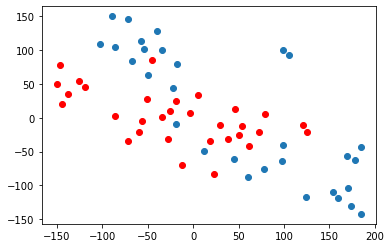